In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import packages and formatting statements

import numpy as np
from matplotlib import pyplot as plt
import astropy.io.fits as pyfits
from astropy.table import Table, join, Column
from astropy.wcs import WCS
from astropy.io import ascii
import os

plt.rc('text',usetex=False)
fontsize=20
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

In [3]:
# Compile galaxy and OSC objects
DataFile = '../Data/0.MUSEdata.csv'
Data = Table.read(DataFile, format='csv') 
galaxies, MUSEres, MUSENatMaps, MUSE150pcMaps = Data["Galaxy"], Data["MUSENatRes"], Data["MUSEmapNat"], Data["MUSEmap150pc"]
SNe = np.loadtxt('../Data/1.FullCatalog.csv', dtype = str, delimiter = ",",unpack=True, usecols = 0)
ras = np.loadtxt('../Data/1.FullCatalog.csv',delimiter=',', unpack = True, usecols=4)
decs = np.loadtxt('../Data/1.FullCatalog.csv',delimiter=',',unpack = True, usecols = (5))
types = np.loadtxt('../Data/1.FullCatalog.csv', dtype=str,delimiter=',', unpack=True, usecols=6)


In [4]:
#Checks if Supernovae are in an image and reports back their x & y coords if in map

def check_in_image(SNras, SNdecs, SNnames, SNtypes, image):
    
    hdulist  = pyfits.open(image)
    
    map = hdulist["HA6562_FLUX"].data
    #emap = hdulist["HA6562_FLUX_ERR"].data     
    wcs = WCS(hdulist["HA6562_FLUX"].header, naxis=2)
    naxis = wcs._naxis #size of image
    naxis1 = hdulist["HA6562_FLUX"].header['NAXIS1']
    naxis2 = hdulist["HA6562_FLUX"].header['NAXIS2']

        
    coords_arr = np.column_stack((SNras, SNdecs)) # ras and decs now [ra,dec]
    pix_x, pix_y = wcs.wcs_world2pix(SNras,SNdecs,0)

    #use world coordinates of all SNe to see if any fall in image (our version of footprint_contains)

    is_in_x = (pix_x >= 0) & (pix_x <= naxis[0]-1) #because of 0-indexing
    is_in_y = (pix_y >= 0) & (pix_y <= naxis[1]-1)
             
    #get the name, ra, and dec of the SNe that fall in image
    #boolean array indexing (gives back array of Trues and Falses)
    #we are pulling out the SNe that are True and assigning them to own arrays
    name_in_image = np.array(SNnames)[is_in_x & is_in_y]
    type_in_image = np.array(SNtypes)[is_in_x & is_in_y]
    ra_in_image = np.array(SNras)[is_in_x & is_in_y]
    dec_in_image = np.array(SNdecs)[is_in_x & is_in_y]

    x_coord = np.array(pix_x)[is_in_x & is_in_y]
    y_coord = np.array(pix_y)[is_in_x & is_in_y]
    
    return(name_in_image, type_in_image, ra_in_image, dec_in_image, x_coord, y_coord, map, naxis1, naxis2)
    #print(name_in_image, type_in_image, ra_in_image, dec_in_image, x_coord, y_coord)


In [5]:
# MEASURE INTENSITY and Build MUSE Catalogue That has all supernovae within PHANGS-MUSE footprint

with open('../Data/2.MUSESNeInt.txt', 'w') as text_file:
    print('#Galaxy,Supernova,Type,Ra,Dec,MUSERes,MUSENatMap,MUSE150pcMap, MUSE150pcInt', file = text_file)

for i in range(len(galaxies)):
    if (MUSE150pcMaps[i] != "" and os.path.isfile(MUSE150pcMaps[i])):
    
        found_name, found_type, found_ra, found_dec, x_coord, y_coord, map, naxis1, naxis2 = check_in_image(ras, decs, SNe, types, MUSE150pcMaps[i])
        intensity = []
    
        for k in range(len(found_type)):

            xVal = int(round(x_coord[k]))
            yVal = int(round(y_coord[k]))
            if (yVal <= naxis2) and (xVal <= naxis1):
                intensity.append(map[yVal, xVal])

            else: 
                intensity.append(np.nan)


        with open('../Data/2.MUSESNeInt.txt', 'a') as text_file:
            for j in range(len(found_name)):
                print(galaxies[i], ",", found_name[j],",", found_type[j],",", found_ra[j], ",",found_dec[j],
                      ",", MUSEres[i],",", MUSENatMaps[i],",", MUSE150pcMaps[i],",", intensity[j], file = text_file)


In [6]:
# Turn files into data structure and clean

MUSEdataFile = '../Data/2.MUSESNeInt.txt'
database = Table.read(MUSEdataFile, format='ascii') 
database[0:2]

Galaxy,Supernova,Type,Ra,Dec,MUSERes,MUSENatMap,MUSE150pcMap,MUSE150pcInt
str7,str11,str12,float64,float64,float64,str80,str78,float64
NGC0628,SN2013ej,II,24.200670833333334,15.758611111111112,0.92,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC0628-0.92asec_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/150pc/NGC0628-150pc_MAPS.fits,nan
NGC0628,SN2019krl,IIn/LBV,24.2067875,15.77946388888889,0.92,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC0628-0.92asec_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/150pc/NGC0628-150pc_MAPS.fits,88.1635392637121


In [7]:

SN_name = [x[2:-2] for x in database["Supernova"]]

# Here we are going to filter out our undesired OSC entries:
    # One is a double counted SN named "PTSS-19clju", any LRNs or LBVs, and any candidates

flags = []
flag1 = database['Supernova'] == "PTSS-19clju" 
flag3 = database['Supernova'] == "Gaia21fml" 
flag5 = database['Supernova'] == "Gaia21cum"
flag6 = database["Supernova"] =="SN2013ej" 
flag7 = database["Supernova"] =="SN1979C"

flag2 = []

for i in range(len(SN_name)):
    if ("LRN" in database['Type'][i] or "LBV" in database['Type'][i] or "Candidate" in database['Type'][i]):
        flag2.append(True)
    else:
        flag2.append(False)

for i in range(len(flag1)):
    if flag1[i] == True or flag2[i] == True or flag3[i] == True or flag5[i] == True or flag6[i] == True or flag7[i] == True:
        flags.append(False)
    else:
        flags.append(True)
        
flagsArr = np.array(flags)

c = Column(data=flags, name='InSample')
database.add_column(c)
ascii.write(database, '../Data/2.MUSEMasterCat.csv', format='csv', fast_writer=False, overwrite = True) 

cleanData = database[flagsArr==True]

cleanData

ascii.write(cleanData, '../Data/2.MUSESampleCat.csv', format='csv', fast_writer=False, overwrite = True)  

In [8]:
cleanData[0:2]

Galaxy,Supernova,Type,Ra,Dec,MUSERes,MUSENatMap,MUSE150pcMap,MUSE150pcInt,InSample
str7,str11,str12,float64,float64,float64,str80,str78,float64,bool
NGC1087,SN1995V,II,41.61154166666667,-0.49878055555555556,0.92,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1087-0.92asec_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/150pc/NGC1087-150pc_MAPS.fits,2851.421676185079,True
NGC1365,SN1957C,Unclassified,53.38349999999999,-36.11770833333333,1.15,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1365-1.15asec_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/150pc/NGC1365-150pc_MAPS.fits,1864.5543905682587,True


In [9]:
# Plot MUSE Galaxy Files with SNe using native resolutions 
inMuse = []

for i in range(len(cleanData["Galaxy"])):
    
    if (cleanData["MUSENatMap"][i] != "" and os.path.isfile(cleanData["MUSENatMap"][i])):     
    
        found_name, found_type, found_ra, found_dec, x_coord, y_coord, map, naxis1, naxis2 = check_in_image(cleanData['Ra'],
                                            cleanData['Dec'], cleanData['Supernova'], cleanData['Type'], cleanData["MUSENatMap"][i])
    
        plt.figure(figsize=(7, 7))
        logmap = np.log10(map)
        plt.imshow(logmap, origin='lower', interpolation='nearest', zorder=1)

        for k in range(len(found_name)):
            inMuse.append(found_name[k])
            string = found_name[k]

            if (len(found_type[k])>1):
                if found_type[k][1] == "I":
                    #colorCode = 'chartreuse'
                    colorCode = 'black'
                    mkr = '*'
                elif found_type[k][1] == "b" or found_type[k][1] == "c":
                    #colorCode = 'salmon'
                    colorCode = 'darkblue'
                    mkr = '^'
                elif found_type[k][1] == "a":
                    #colorCode = 'deeppink'
                    colorCode = 'indigo'
                    mkr = 'o'
                else:
                    colorCode = 'magenta'
                    mkr = '>'
            else:
                #colorCode = 'cyan'
                colorCode = 'maroon'
                mkr='s'

            plt.plot(x_coord[k], y_coord[k], marker=mkr, ms=10, color=colorCode, zorder=10)
            plt.text(x_coord[k]-20, y_coord[k]+8, string, fontsize=12, color=colorCode)

        plt.axis('off')
        plt.title(cleanData["Galaxy"][i], fontsize=24, fontweight='bold')
        plt.tight_layout()
        plt.savefig('../Figures/GalaxyImages/' + cleanData["Galaxy"][i] + '.png')
        plt.close()

In [10]:
#Group data by galaxy
gal_groups = cleanData.group_by('Galaxy')
gals = gal_groups.groups.keys
indices = gal_groups.groups.indices
indices = indices.tolist()
indices.append(0)

# print(gals)
# print(indices)

galaxies, images, name, types, ras, decs = [],[],[],[],[],[]
# errfiles, dists = [],[]
for i in range(len(indices)-2):
    
    SNnames, SNtypes, SNras, SNdecs = [],[],[],[]
    images.append(gal_groups["MUSENatMap"][indices[i]])
    SNnames.append(gal_groups["Supernova"][indices[i]])
    SNtypes.append(gal_groups["Type"][indices[i]])
    SNras.append(gal_groups["Ra"][indices[i]])
    SNdecs.append(gal_groups["Dec"][indices[i]])
    j = 1
    
    while(indices[i] + j < indices[i+1]):
        SNnames.append(gal_groups["Supernova"][indices[i]+j])
        SNtypes.append(gal_groups["Type"][indices[i]+j])
        SNras.append(gal_groups["Ra"][indices[i]+j])
        SNdecs.append(gal_groups["Dec"][indices[i]+j])
        j += 1
    
    if len(SNnames) != 0:
        name.append(SNnames)
        types.append(SNtypes)
        ras.append(SNras)
        decs.append(SNdecs)
        galaxies.append(gals[i][0])

print(decs)
print(galaxies)

[[-0.49878055555555556], [-36.11770833333333, -36.148580555555554, -36.142, -36.12713888888889], [-47.21], [-54.93807777777778, -54.94403055555555, -54.94808055555555], [-59.24513888888889, -59.245383333333336], [12.996388888888887, 13.005277777777778, 12.972111111111111, 12.979611111111112, 12.9824], [14.41404861111111, 14.44432638888889, 14.412330555555556, 14.412080555555557], [4.493354166666666, 4.470361111111111, 4.473770833333334, 4.462669444444445, 4.4879694444444445, 4.471811111111111, 4.481680555555556], [15.82375, 15.816989814814816, 15.80918888888889, 15.826119444444444, 15.823599999999999]]
['NGC1087', 'NGC1365', 'NGC1433', 'NGC1566', 'NGC1672', 'NGC3627', 'NGC4254', 'NGC4303', 'NGC4321']


In [11]:
# set up plots.
import matplotlib.pyplot as plt
SNgals, plots, wcss, legendLabels = [],[],[],[]
# beamsizes, plotAspect, ppb, corner, scalebars = [],[],[],[],[],[],[],[],[]


for i in range(len(galaxies)):
        
    if os.path.isfile(images[i]):
        SNgals.append(galaxies[i])
        img = images[i]
        hdu = pyfits.open(img)
        img_map = hdu["HA6562_FLUX"].data
        plots.append(img_map)
        w = WCS(hdu["HA6562_FLUX"].header, naxis=2)
        wcss.append(w)
        
        legendlabel = []
        if len(name[i]) > 1:
            for k in range(len(name[i])):
                if types[i][k] == 'Unclassified':
                    typelabel = name[i][k] + ' '  + types[i][k]
                else:
                    typelabel = name[i][k] + ' Type '  + types[i][k]
                legendlabel.append(typelabel)
        else:
            if types[i][0] == 'Unclassified':
                legendlabel.append(name[i][0] + ' '  + types[i][0]) 
            else:        
                legendlabel.append(name[i][0] + ' Type '  + types[i][0])
        legendLabels.append(legendlabel)
        
# print(legendLabels)
# print(SNgals)
# print(len(plots))
# for i in range(len(SNgals)):
#     for j in range(len(ras[i])):
#         print(SNgals[i], ras[i][j])

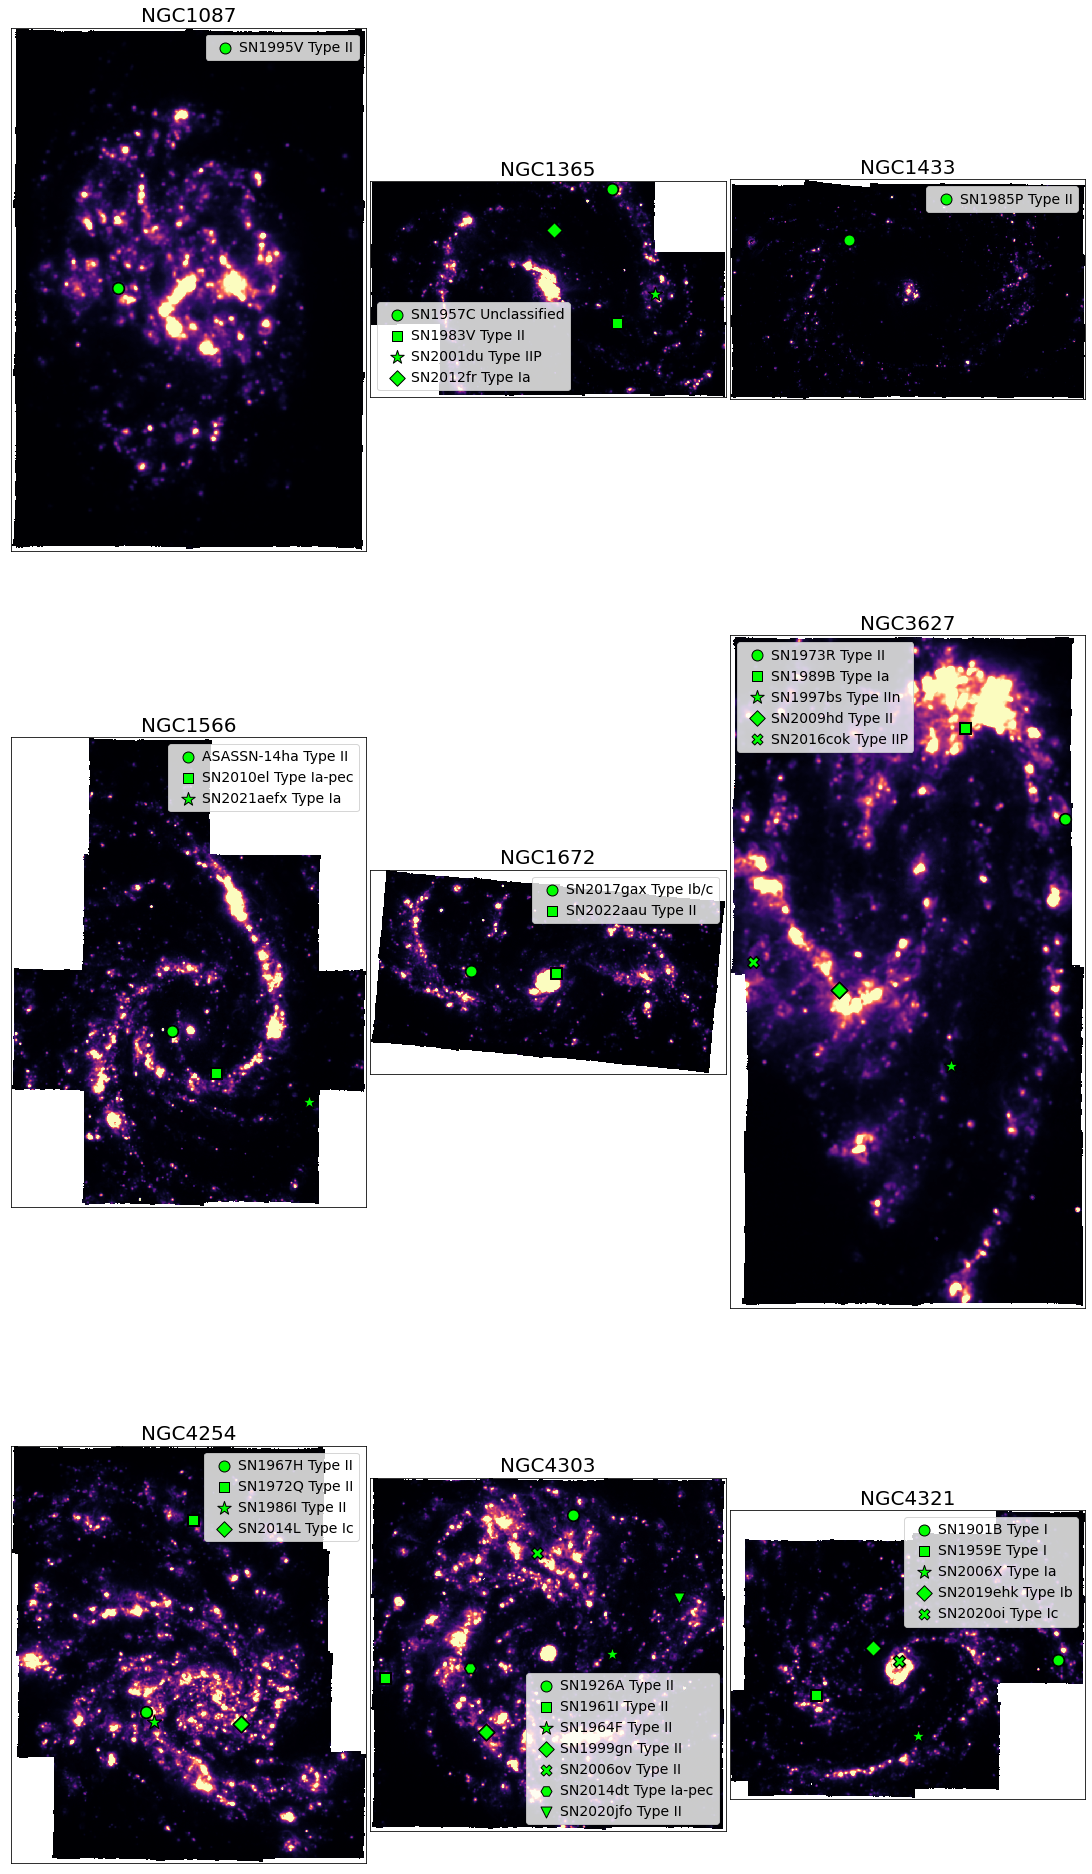

In [12]:
from matplotlib.patches import Circle


markerShapes = ["o", "s", "*", "D", "X", "H", "v"]
markerSizes  = [120,120,200,120,120,120,120]

current_cmap = plt.get_cmap("magma")
current_cmap.set_bad("white")

import math
i,j,m=0,0,0
PLOTS_PER_ROW = 3
fig, axs = plt.subplots(math.ceil(len(plots)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(15, 30))
for plot in plots:

    xArr, yArr = wcss[m].wcs_world2pix(ras[m],decs[m],0)
    logplot = np.log10(plot)
    axs[i][j].imshow(plot, cmap=current_cmap, aspect="equal", origin = "lower", interpolation = "nearest",
                    vmin=-0.1, vmax=10000)
    axs[i][j].set_title(SNgals[m].upper(), fontsize=20)
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])
    for n in range(len(decs[m])):
        axs[i][j].scatter(xArr[n], yArr[n], color = "black", marker = markerShapes[n], s = markerSizes[n]+30)
        axs[i][j].scatter(xArr[n], yArr[n], color = "lime", marker = markerShapes[n], s = markerSizes[n], 
                          edgecolor="black", label = legendLabels[m][n])
    axs[i][j].legend(loc="best", fontsize=14, handletextpad=0.007)

    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
    m +=1
plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
plt.show()
fig.savefig("../Figures/MUSEGalaxies.pdf", dpi=300)
   

print()

In [13]:
cleanData

Galaxy,Supernova,Type,Ra,Dec,MUSERes,MUSENatMap,MUSE150pcMap,MUSE150pcInt,InSample
str7,str11,str12,float64,float64,float64,str80,str78,float64,bool
NGC1087,SN1995V,II,41.61154166666667,-0.49878055555555556,0.92,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1087-0.92asec_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/150pc/NGC1087-150pc_MAPS.fits,2851.421676185079,True
NGC1365,SN1957C,Unclassified,53.38349999999999,-36.11770833333333,1.15,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1365-1.15asec_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/150pc/NGC1365-150pc_MAPS.fits,1864.5543905682587,True
NGC1365,SN1983V,II,53.38192083333333,-36.148580555555554,1.15,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1365-1.15asec_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/150pc/NGC1365-150pc_MAPS.fits,4541.710462001076,True
NGC1365,SN2001du,IIP,53.371249999999996,-36.142,1.15,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1365-1.15asec_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/150pc/NGC1365-150pc_MAPS.fits,918.7055209818459,True
NGC1365,SN2012fr,Ia,53.39995833333333,-36.12713888888889,1.15,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1365-1.15asec_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/150pc/NGC1365-150pc_MAPS.fits,102.90598202855041,True
NGC1433,SN1985P,II,55.526500000000006,-47.21,0.91,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1433-0.91asec_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/150pc/NGC1433-150pc_MAPS.fits,174.71661018812813,True
NGC1566,ASASSN-14ha,II,65.0058875,-54.93807777777778,0.8,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1566-0.80asec_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/150pc/NGC1566-150pc_MAPS.fits,3053.614935125523,True
NGC1566,SN2010el,Ia-pec,64.99512083333333,-54.94403055555555,0.8,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1566-0.80asec_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/150pc/NGC1566-150pc_MAPS.fits,320.1414131766342,True
NGC1566,SN2021aefx,Ia,64.9725,-54.94808055555555,0.8,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/copt/NGC1566-0.80asec_MAPS.fits,/data/fourier/sun.1608/PHANGS/MUSE/DR2.2/MUSEDAP/150pc/NGC1566-150pc_MAPS.fits,117.0347673829065,True
